In [1]:
# Standard library
import os
import re
import sys
import warnings
from pathlib import Path

# Third-party - Data and scientific computing
import contextily as cx
import geopandas as gpd
import igraph as ig
import numpy as np
import pandas as pd
import xarray as xr
from pyproj import Geod
from tqdm import tqdm
from damagescanner.core import DamageScanner

#  Shapely-specific imports for spatial analysis
import shapely
from shapely import STRtree
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import nearest_points, snap

# Matplotlib-specific imports for figures
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.ticker import FuncFormatter, MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [2]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "input_files"
figure_path = BASE_DIR / "figures"
intermediate_results_path = BASE_DIR / 'intermediate_results'

In [3]:
gdf_results = gpd.read_parquet(intermediate_results_path / "criticality_results.parquet")

In [4]:
# Load country outline
world_path =  data_path / "ne_10m_admin_0_countries.shp"
world = gpd.read_file(world_path)
country_plot = world.loc[world.SOV_A3 == 'SRB']

# read flood data
flood_path = data_path / "Europe_RP100_filled_depth.tif"

country_bounds = world.loc[world.SOV_A3 == 'SRB'].bounds
country_geom = world.loc[world.SOV_A3 == 'SRB'].geometry

hazard_map = xr.open_dataset(flood_path, engine="rasterio")
hazard_country = hazard_map.rio.clip_box(minx=country_bounds.minx.values[0],
                 miny=country_bounds.miny.values[0],
                 maxx=country_bounds.maxx.values[0],
                 maxy=country_bounds.maxy.values[0]
                ).load()

exposed_roads = DamageScanner(
    hazard_country, 
    gdf_results, 
    curves=pd.DataFrame(), 
    maxdam=pd.DataFrame()
).exposure(asset_type='roads',disable_progress=False)


convert coverage to meters: 100%|██████████| 1289/1289 [00:03<00:00, 404.99it/s]


In [5]:
def flagged_exposed_segments(row):
        return any(val > 0.25 for val in row['values'])

def max_depth(row):
        return np.max(row['values'])

exposed_roads['exposed'] = exposed_roads.progress_apply(flagged_exposed_segments, axis=1)
exposed_roads['max_depth'] =  exposed_roads.progress_apply(max_depth, axis=1)

convert coverage to meters: 100%|██████████| 1289/1289 [00:00<00:00, 87561.06it/s]


In [6]:
gdf_vhl_flooded = gdf_results.merge(exposed_roads.loc[exposed_roads.exposed][['coverage','values','max_depth']],left_index=True,right_index=True)

In [7]:
gdf_vhl_flooded

,from_id,to_id,objectid,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,...,distance_disruption,time_disruption,vhl,phl,thl,pkl,tkl,coverage,values,max_depth
4,12,13,5.0,A1023,D,IA,A1,A111,petlja Novi Sad sever,A112,...,2.300461e-04,2.300461e-04,665.862164,1315.217192,1550.605601,105217.375339,124048.448081,"[7.98187616196413, 70.26538601103236, 69.90608...","[0.13600000739097595, 0.7319999933242798, 0.73...",1.663
6,16,17,8.0,A1004,L,IA,A1,A102,petlja Subotica sever,A101,...,3.768578e-06,3.768578e-06,11.222818,23.674288,25.570734,1893.943015,2045.658681,"[88.6440373255492, 88.51560155956756, 88.42867...","[1.0, 0.43799999356269836, 0.4399999976158142,...",1.000
10,20,21,9.0,A1024,L,IA,A1,A112,petlja Novi Sad centar,A111,...,2.348411e-04,2.348411e-04,127.833727,252.498378,297.688778,20199.870205,23815.102233,"[65.32851164404711, 67.4971709839168, 67.11328...","[0.7319999933242798, 0.7310000061988831, 0.828...",1.663
13,25,26,11.0,A1006,L,IA,A1,A103,petlja Subotica istok,A102,...,5.465659e-05,5.465659e-05,8.662728,17.641686,19.932402,1411.334870,1594.592166,[77.13776407862304],[1.0],1.000
23,36,37,15.0,A1009,D,IA,A1,A104,petlja Subotica jug,A105,...,3.565594e-06,3.565594e-06,31.098562,63.274220,68.310163,5061.937630,5464.813016,[91.49012157991058],[1.7929999828338623],1.793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,1015,1014,793.0,03915,O,IB,39,3915,Lebane (Kriva?a),3916,...,1.368642e-03,1.368642e-03,160.986970,337.805597,107.178411,27024.447799,8574.272851,"[39.62087594746599, 48.54649101258296, 74.9641...","[0.4339999854564667, 1.4170000553131104, 1.414...",4.895
3128,1056,622,865.0,12903,O,IIA,129,1313,Perlez (Kova?ica),12901,...,3.558302e-04,3.558302e-04,15.063271,33.072718,7.046649,2645.817432,563.731955,"[12.533933617758928, 87.52740258683484, 88.930...","[0.11599999666213989, 0.12099999934434891, 0.1...",6.753
3130,1159,1776,1631.0,30901,O,IIB,309,30801,Krajišnik,12905,...,2.448769e-07,2.448769e-07,0.000004,0.000008,0.000002,0.000658,0.000192,"[42.39870878895252, 68.0903777951096, 68.23868...","[0.5540000200271606, 0.2540000081062317, 0.245...",0.642
3131,2070,2071,211.0,,,,A1,dA15406,,3908,...,4.001042e-06,4.001042e-06,NaN,NaN,NaN,NaN,NaN,"[32.43567355600987, 68.11346615119713, 57.6752...","[0.3190000057220459, 0.1469999998807907, 0.188...",0.537


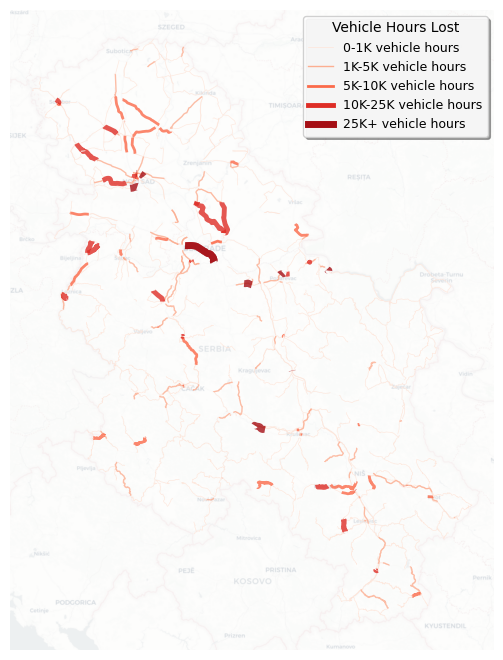

In [8]:
# Define bins based on vehicle hours lost distribution - heavily skewed toward 0
bins = [0, 1000, 5000, 10000, 25000, np.inf]
labels = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']

# Create binned column
gdf_vhl_flooded['vhl_class'] = pd.cut(
    gdf_vhl_flooded['vhl'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Define line widths for each class (higher VHL = thicker lines)
linewidth_map = {
    '0-1K': 0.5,
    '1K-5K': 1.0,
    '5K-10K': 2.0,
    '10K-25K': 3.5,
    '25K+': 5.0
}

# Create a linewidth column
gdf_vhl_flooded['linewidth'] = gdf_vhl_flooded['vhl_class'].map(linewidth_map)

# Create figure with high DPI for crisp visuals
fig, ax = plt.subplots(1, 1, figsize=(20, 8), facecolor='white')

# Plot each class separately with both width and color variation
# Using red-orange color progression for impact severity
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']

for i, (class_name, width) in enumerate(linewidth_map.items()):
    subset = gdf_vhl_flooded[gdf_vhl_flooded['vhl_class'] == class_name]
    if not subset.empty:
        subset.to_crs(3857).plot(
            ax=ax,
            color=colors[i],
            linewidth=width,
            alpha=0.8,
            label=class_name
        )

# Add basemap with optimal styling
cx.add_basemap(ax=ax,
    source=cx.providers.CartoDB.Positron,
                alpha=0.4, 
                attribution=False)


# Enhance the plot styling
ax.set_aspect('equal')
ax.axis('off')

# Create custom legend with line samples that show both width and color
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=colors[i], lw=width, label=f'{class_name} vehicle hours')
                  for i, (class_name, width) in enumerate(linewidth_map.items())]

legend = ax.legend(handles=legend_elements, 
                  title='Vehicle Hours Lost', 
                  loc='upper right',
                  fontsize=9,
                  title_fontsize=10,
                  frameon=True,
                  fancybox=True,
                  shadow=True,
                  framealpha=0.9,
                  facecolor='white',
                  edgecolor='#cccccc')

# Enhance overall plot appearance
plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.08, left=0.02, right=0.94)
plt.savefig(figure_path / 'vehicle_hours_lost_map_flooded.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
snow_drift = gpd.read_file(data_path / "snezni_nanosi_studije.shp")

c:\Users\yma794\AppData\Local\miniforge3\envs\serbia\Lib\site-packages\pyogrio\raw.py:200: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


In [10]:
gdf_vhl_snowdrift = gdf_results[['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'road_length', 'speed', 'fft','edge_no', 'vhl','phl','thl','pkl','tkl']].sjoin(snow_drift)

In [11]:
landslides = gpd.read_file(data_path / "Nestabilne_pojave.shp")
landslides.geometry = landslides.geometry.buffer(10)

In [12]:
gdf_vhl_landslides = gdf_results[['from_id', 'to_id', 'objectid', 'oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry', 'id',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'road_length', 'speed', 'fft','edge_no','vhl','phl','thl','pkl','tkl']].sjoin(landslides)

In [13]:
gdf_vhl_landslides

,from_id,to_id,objectid_left,oznaka_deo_left,smer_gdf1,kategorija_left,oznaka_put_left,oznaka_poc,naziv_poce,oznaka_zav,...,objectid_right,id_nestabi,tip,lokalni_na,oznaka_put_right,oznaka_deo_right,kategorija_right,datum_evid,x,y
90,115,116,55.0,A1069,D,IA,A1,A134,petlja Kolari,A135,...,90,NP-A1-259.360,Klizište,Smederevska petlja,A1,A1069,IA,2008-09-08,7.494518e+06,4.936618e+06
95,122,123,58.0,A1031,D,IA,A1,A115,petlja Kovilj,A116,...,413,NP-A1-139.150,Klizište,Beška,A1,A1031,IA,2008-01-31,7.428115e+06,5.002885e+06
149,179,180,80.0,A1062,L,IA,A1,A131,petlja Mali Požarevac,A130,...,67,NP-A1-230.761,Klizište,Begaljičko brdo 2,A1,A1062,IA,2010-04-02,7.471828e+06,4.941860e+06
153,183,184,81.0,A1071,D,IA,A1,A135,petlja Smederevo,A136,...,92,NP-A1-263.330,Klizište,Požarevačka petlja,A1,A1071,IA,2010-04-27,7.498240e+06,4.937596e+06
183,215,113,92.0,A1067,D,IA,A1,A133,petlja Vodanj,A134,...,77,NP-A1-255.837,Klizište,Kolari,A1,A1067,IA,2002-08-29,7.491161e+06,4.937172e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,864,1597,1941.0,14301,O,IIA,143,2711,Pri?evi?,14111,...,263,NP-143-0.260,Otcepljenje kosine zaseka,Pričević,143,14301,IIA,2014-12-18,7.401732e+06,4.905794e+06
2170,1823,1838,1942.0,35801,O,IIB,358,35701,Kadina Luka (Ba),35601,...,219,NP-358-8.180,Klizište,Srasle Bukve,358,35801,IIB,2016-08-25,7.435105e+06,4.890265e+06
2170,1823,1838,1942.0,35801,O,IIB,358,35701,Kadina Luka (Ba),35601,...,220,NP-358-8.230,Klizište,Srasle Bukve,358,35801,IIB,2014-08-13,7.435095e+06,4.890324e+06
3124,617,475,338.0,01312o3,O,IB,13,1310.1,/,1311,...,279,NP-13-123.890,Otcepljenje kosine nasipa,Zrenjanin,13,01312o3,IB,2018-08-13,7.454819e+06,5.025372e+06


In [14]:
# pick an aggregation rule for duplicates; here we use 'max' as an example
s_depth = gdf_vhl_flooded['max_depth'].groupby(level=0).max()
s_snow  = gdf_vhl_snowdrift['dužina_sn'].groupby(level=0).max()
s_date  = gdf_vhl_landslides['datum_evid'].groupby(level=0).max()

# align everything to the base index
gdf_hazards = pd.concat([gdf_results, s_depth.rename('max_depth'),
                         s_snow.rename('dužina_sn'),
                         s_date.rename('datum_evid')], axis=1)

# convert date to string dd/mm/yyyy (NaT -> NaN -> optional empty string)
gdf_hazards['datum_evid'] = gdf_hazards['datum_evid'].dt.strftime('%d/%m/%Y')


In [15]:
keep_attrs = ['oznaka_deo', 'smer_gdf1', 'kategorija',
       'oznaka_put', 'oznaka_poc', 'naziv_poce', 'oznaka_zav', 'naziv_zavr',
       'duzina_deo', 'pocetna_st', 'zavrsna_st', 'stanje', 'geometry',
       'passenger_cars', 'buses', 'light_trucks', 'medium_trucks',
       'heavy_trucks', 'articulated_vehicles', 'total_aadt', 'road_length', 'average_time_disruption','vhl','phl','thl','pkl','tkl','max_depth', 'dužina_sn', 'datum_evid']
gdf_hazards = gdf_hazards[keep_attrs]
gdf_hazards = gdf_hazards.loc[gdf_hazards[['max_depth', 'dužina_sn', 'datum_evid']].any(axis=1)]
gdf_hazards = gdf_hazards.loc[gdf_hazards['vhl'].notna()]

In [16]:
mask = (
    (gdf_hazards['max_depth'].fillna(0) > 0) &
    (gdf_hazards['dužina_sn'].fillna(0) > 0) &
    (gdf_hazards['datum_evid'].notna()))

affected_all = gdf_hazards.loc[mask]

In [17]:
affected_all

,oznaka_deo,smer_gdf1,kategorija,oznaka_put,oznaka_poc,naziv_poce,oznaka_zav,naziv_zavr,duzina_deo,pocetna_st,...,road_length,average_time_disruption,vhl,phl,thl,pkl,tkl,max_depth,dužina_sn,datum_evid
272,A1101,D,IA,A1,A150,petlja Merošina,A151,petlja Doljevac,10.614,440.599,...,10.289949,0.012127,170.847393,353.676418,294.214540,28294.113448,23537.163199,3.408000,5.500,13/03/2018
280,A1102,L,IA,A1,A151,petlja Doljevac,A150,petlja Merošina,10.590,451.213,...,10.296632,0.060029,845.684449,1750.677262,1456.344497,140054.180968,116507.559787,3.608000,5.500,27/04/2010
634,02135,O,IB,21,2133,Ivanjica,2134,Sjenica,61.336,249.951,...,61.278137,0.085001,82.961366,158.612612,45.008241,12689.008972,3600.659298,21.117001,6.000,03/08/2015
661,02234,O,IB,22,2233,Novi Pazar (Br?ani),2234,Ribari?e,24.390,257.678,...,24.325802,0.096981,639.784056,1335.623164,246.370686,106849.853151,19709.654876,3.697000,5.000,06/12/2022
698,02334,O,IB,23,2332,Pakovra?e (veza sa A2),2316,Kratovska Stena,17.745,97.799,...,17.748107,0.116892,1713.635256,3501.847544,2183.727722,280147.803548,174698.217730,23.402000,10.201,11/04/2017
847,03510,O,IB,35,3510,Salaš,3511,Rgotina,19.485,87.256,...,19.489588,0.061115,111.840213,214.513195,121.881386,17161.055616,9750.510888,3.084000,3.000,21/04/2015
888,03904,O,IB,39,3904,Babušnica,3905,Bonjince,17.253,24.028,...,17.239568,0.000534,0.626739,1.165926,0.317693,93.274071,25.415476,9.877000,10.100,06/09/2023
897,03915,O,IB,39,3915,Lebane (Kriva?a),3916,Negosavlje,17.931,99.282,...,17.911049,0.081253,137.155438,287.798910,91.312370,23023.912791,7304.989609,4.895000,13.018,13/03/2018
914,04602,O,IB,46,4601,Kni?,2221,Mr?ajevci,17.370,5.099,...,17.359693,0.504600,3152.234965,6265.111145,3380.515915,501208.891615,270441.273235,1.000000,2.000,02/03/2022
939,10018,O,IIA,100,2192,Petrovaradin jug,10012,Maradik (Beška),18.444,129.325,...,18.438740,0.095086,667.885659,1340.905974,651.939699,107272.477922,52155.175888,5.329000,15.791,04/06/2020


In [18]:
### save outputs

In [19]:
gdf_hazards.to_parquet(intermediate_results_path / "main_network_hazard_exposure.parquet")

### Map of main network impacts

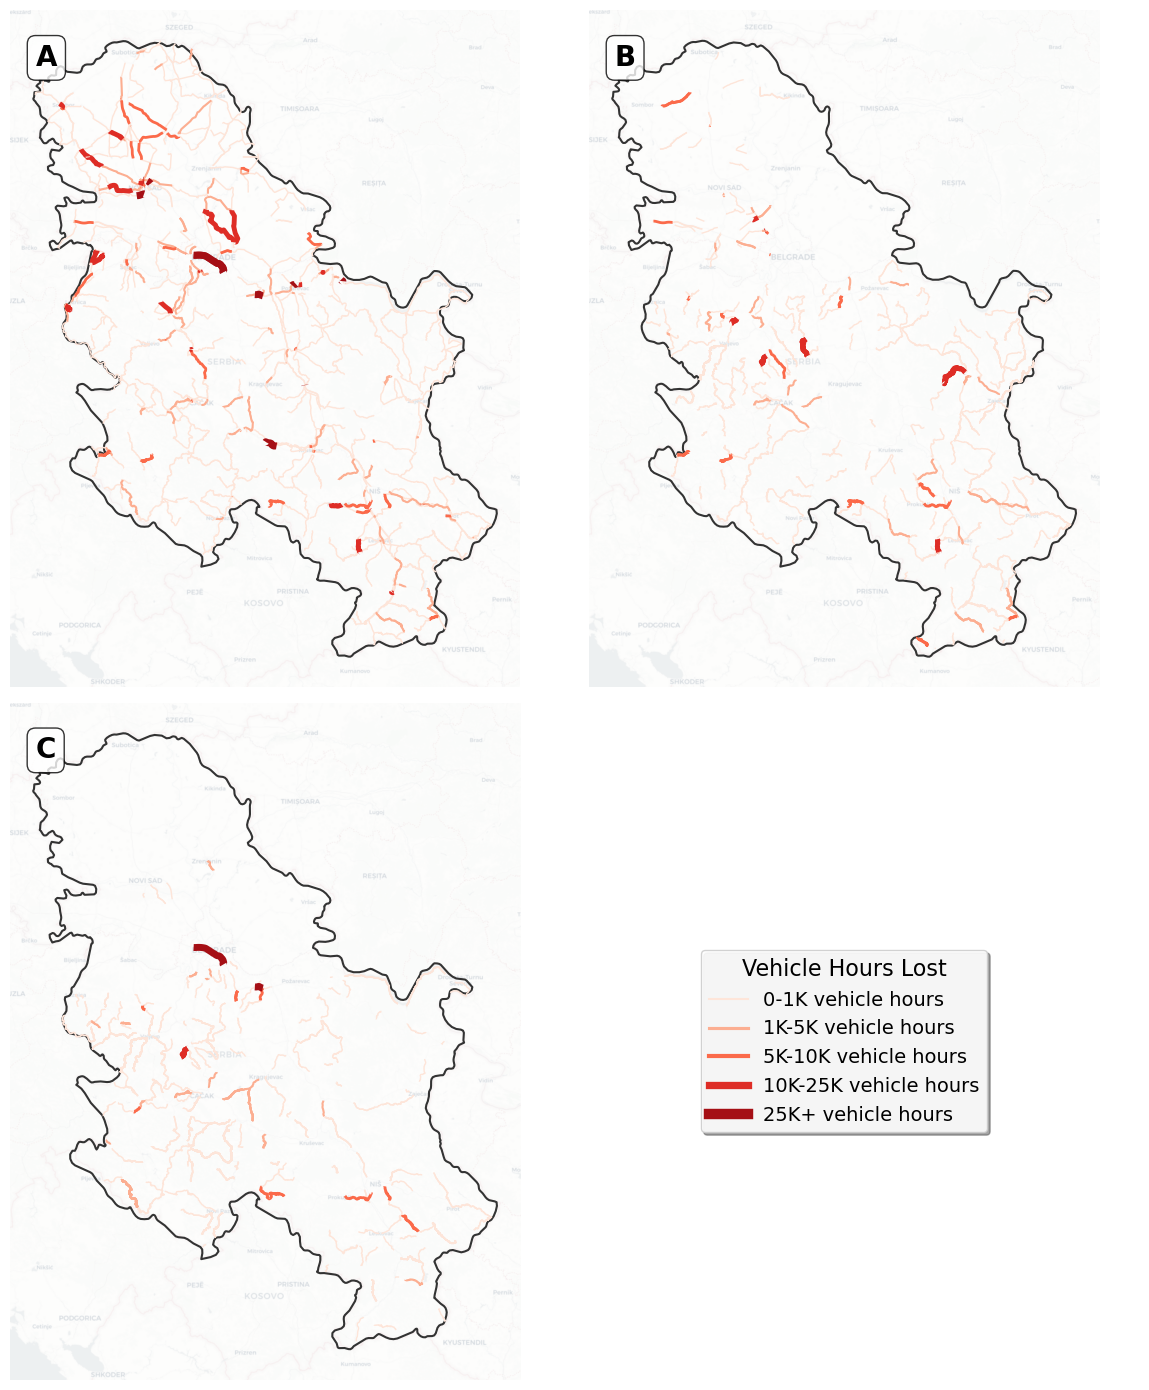

In [20]:
# Define bins and styling (shared across all three)
bins = [0, 1000, 5000, 10000, 25000, np.inf]
labels = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']
linewidth_map = {'0-1K': 1, '1K-5K': 1.5, '5K-10K': 2.0, '10K-25K': 3.5, '25K+': 5.0}

# Prepare all three datasets
datasets = {
    'A': ('Floods', gdf_vhl_flooded),
    'B': ('Snow Drift', gdf_vhl_snowdrift),
    'C': ('Landslides', gdf_vhl_landslides)
}

# Bin all datasets
for letter, (title, gdf) in datasets.items():
    gdf['vhl_class'] = pd.cut(gdf['vhl'], bins=bins, labels=labels, include_lowest=True)

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 14), facecolor='white')
axes = axes.flatten()  # Flatten to [ax_A, ax_B, ax_C, ax_legend]

# Convert country boundary once
serbia_mercator = country_plot.to_crs(3857)

# Plot the three hazard maps
for idx, (letter, (title, gdf)) in enumerate(datasets.items()):
    ax = axes[idx]
    gdf_mercator = gdf.to_crs(3857)
    
    # Plot country outline
    serbia_mercator.plot(ax=ax, facecolor='none', edgecolor='#333333', 
                         linewidth=1.5, zorder=1)
    
    # Plot each VHL class
    for i, (class_name, width) in enumerate(linewidth_map.items()):
        subset = gdf_mercator[gdf_mercator['vhl_class'] == class_name]
        if not subset.empty:
            subset.plot(ax=ax, color=colors[i], linewidth=width, zorder=2)
    
    # Add basemap
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, 
                   alpha=0.4, attribution=False)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add letter label
    ax.text(0.05, 0.95, f'{letter}', transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Use the 4th panel (lower right) for the legend
ax_legend = axes[3]
ax_legend.axis('off')

# Create legend elements
legend_elements = [
    Line2D([0], [0], color=colors[i], lw=width * 1.5, label=f'{class_name} vehicle hours')
    for i, (class_name, width) in enumerate(linewidth_map.items())
]

# Add legend to the empty panel
ax_legend.legend(handles=legend_elements, 
                 title='Vehicle Hours Lost',
                 loc='center',
                 fontsize=14,
                 title_fontsize=16,
                 frameon=True,
                 fancybox=True,
                 shadow=True,
                 framealpha=0.9,
                 facecolor='white',
                 edgecolor='#cccccc')


plt.tight_layout()
plt.savefig('vhl_hazards_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

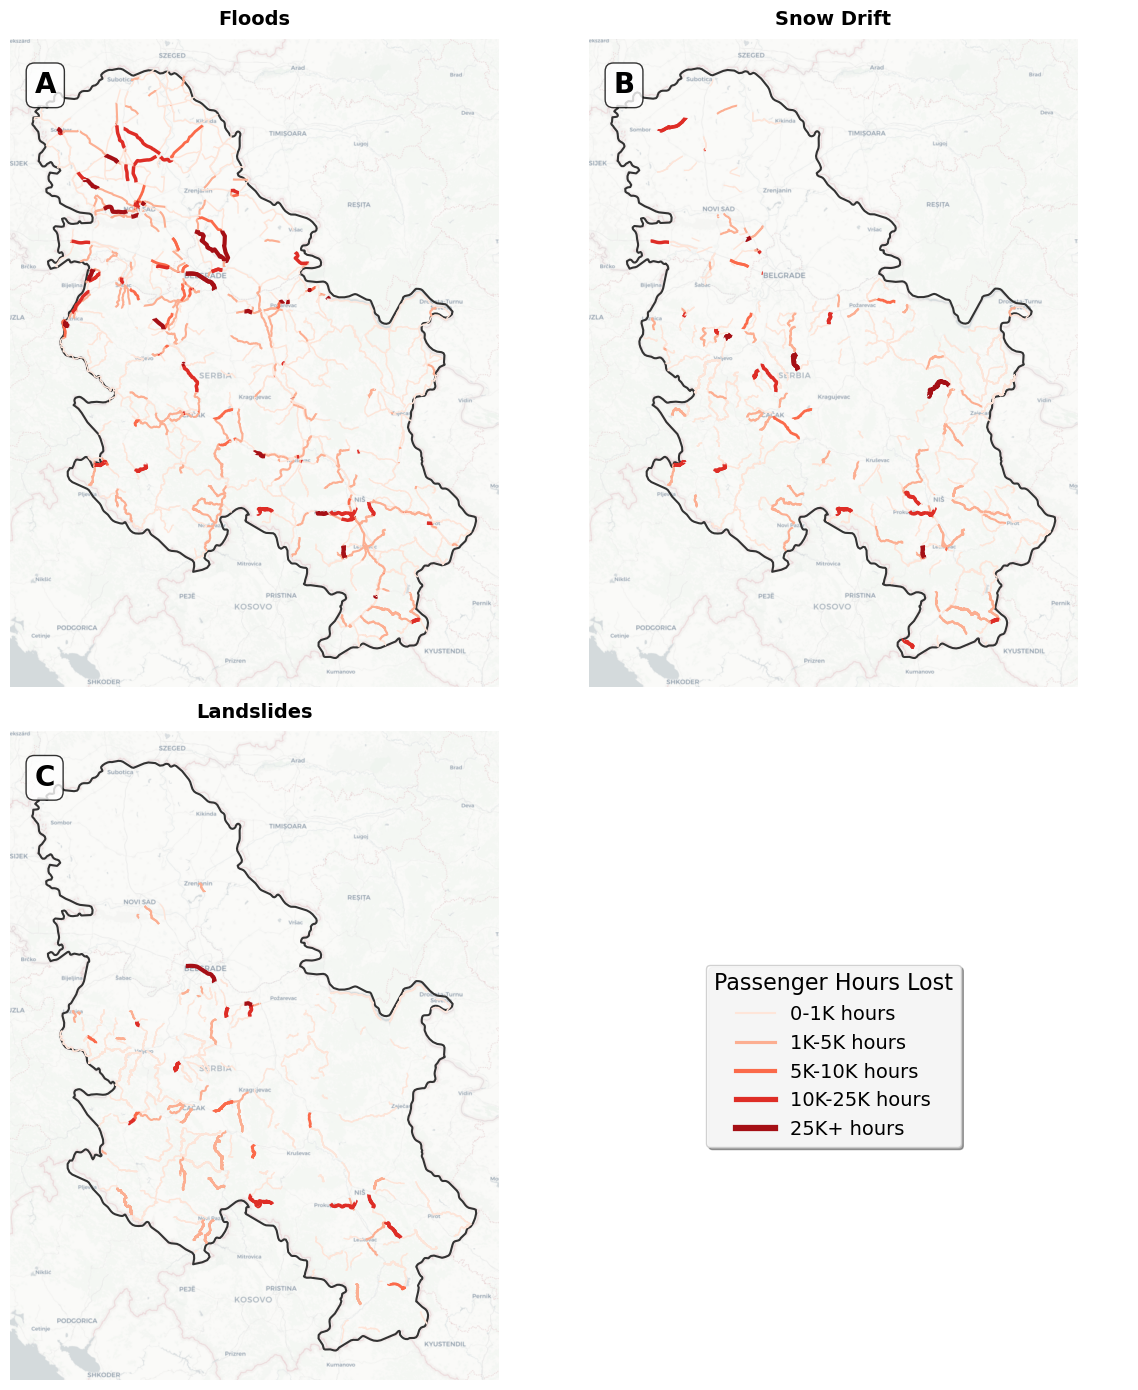

In [21]:
# ============================================================
# FIGURE 1: PASSENGER HOURS LOST BY HAZARD TYPE
# ============================================================

# Define bins and styling for PHL
bins_phl = [0, 1000, 5000, 10000, 25000, np.inf]
labels_phl = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']
colors = ['#fee5d9', '#fcae91', '#fb6a4a', '#de2d26', '#a50f15']
linewidth_map = {'0-1K': 1, '1K-5K': 1.5, '5K-10K': 2.0, '10K-25K': 2.5, '25K+': 3.0}

# Prepare all three datasets for PHL
datasets_phl = {
    'A': ('Floods', gdf_vhl_flooded),
    'B': ('Snow Drift', gdf_vhl_snowdrift),
    'C': ('Landslides', gdf_vhl_landslides)
}

# Bin all datasets
for letter, (title, gdf) in datasets_phl.items():
    gdf['phl_class'] = pd.cut(gdf['phl'], bins=bins_phl, labels=labels_phl, include_lowest=True)

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 14), facecolor='white')
axes = axes.flatten()

# Convert country boundary once
serbia_mercator = country_plot.to_crs(3857)

# Plot the three hazard maps
for idx, (letter, (title, gdf)) in enumerate(datasets_phl.items()):
    ax = axes[idx]
    gdf_mercator = gdf.to_crs(3857)
    
    # Plot country outline
    serbia_mercator.plot(ax=ax, facecolor='none', edgecolor='#333333', 
                         linewidth=1.5, zorder=1)
    
    # Plot each PHL class
    for i, (class_name, width) in enumerate(linewidth_map.items()):
        subset = gdf_mercator[gdf_mercator['phl_class'] == class_name]
        if not subset.empty:
            subset.plot(ax=ax, color=colors[i], linewidth=width, zorder=2)
    
    # Add basemap
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, 
                   attribution=False)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title and letter label
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.text(0.05, 0.95, f'{letter}', transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Use the 4th panel for the legend
ax_legend = axes[3]
ax_legend.axis('off')

legend_elements = [
    Line2D([0], [0], color=colors[i], lw=width * 1.5, label=f'{class_name} hours')
    for i, (class_name, width) in enumerate(linewidth_map.items())
]

ax_legend.legend(handles=legend_elements, 
                 title='Passenger Hours Lost',
                 loc='center',
                 fontsize=14,
                 title_fontsize=16,
                 frameon=True,
                 fancybox=True,
                 shadow=True,
                 framealpha=0.9,
                 facecolor='white',
                 edgecolor='#cccccc')

plt.tight_layout()
plt.savefig(figure_path / 'phl_hazards_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


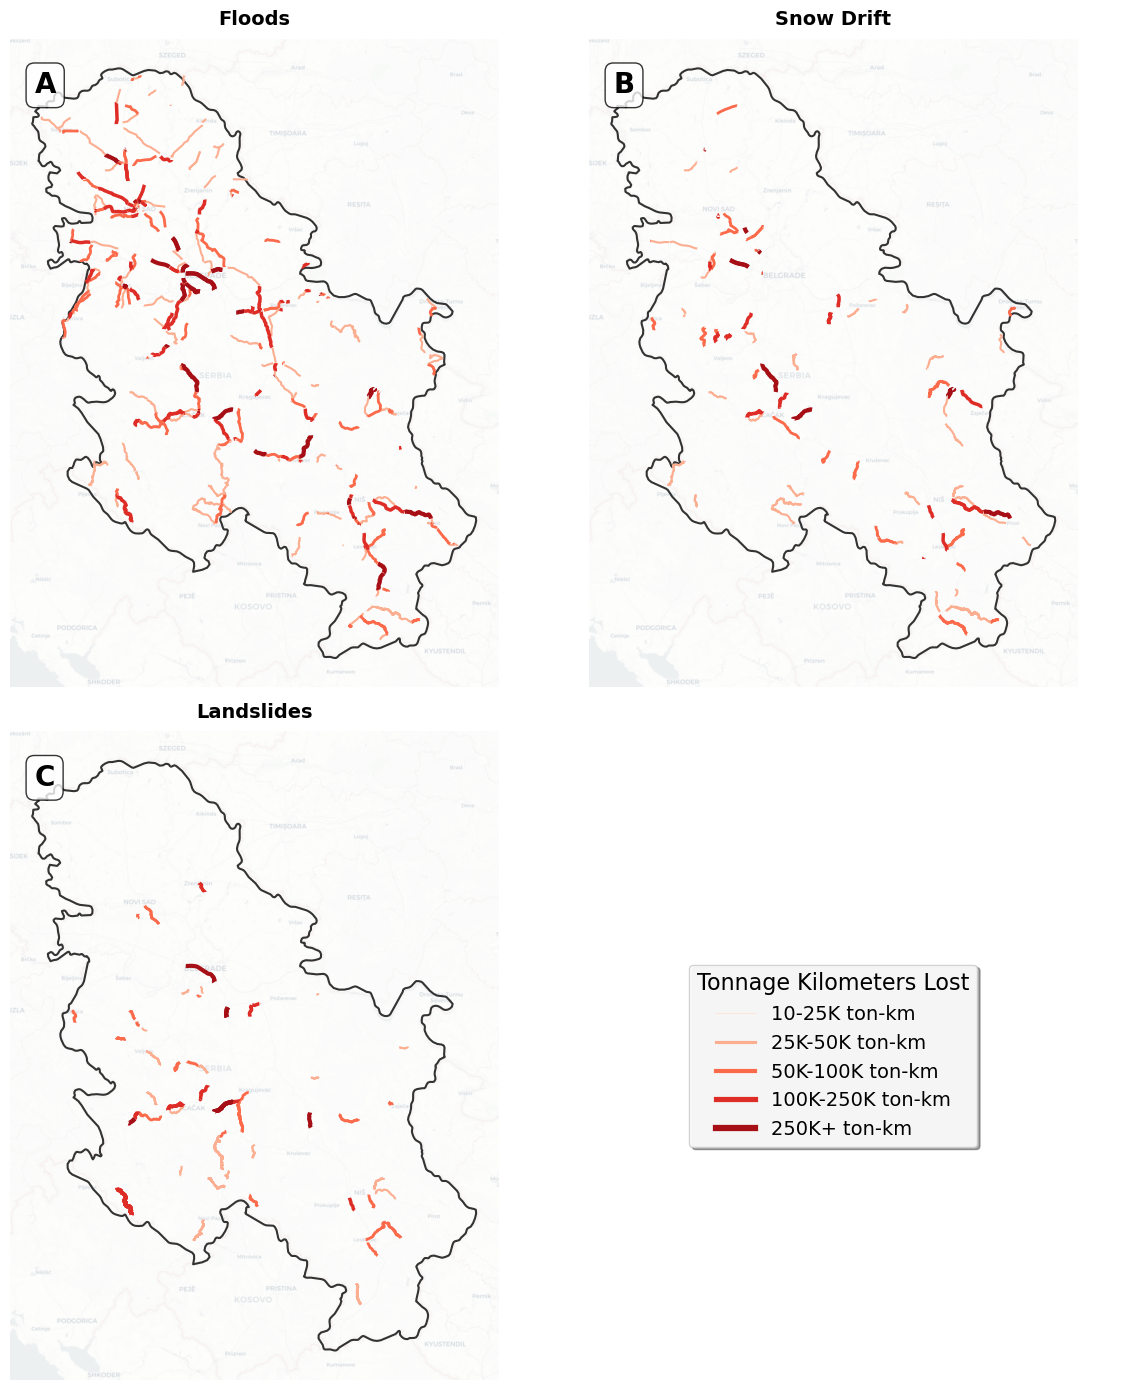

In [22]:

# ============================================================
# FIGURE 2: TONNAGE KILOMETERS LOST BY HAZARD TYPE
# ============================================================

# Define bins and styling for TKL

bins_tkl = [10000, 25000, 50000, 100000, 250000, np.inf]
labels_tkl = ['5K-25K', '25K-50K', '50K-100K', '100K-250K', '250K+']
linewidth_map_tkl = {
    '10-25K': 0.5, '25K-50K': 1.5, '50K-100K': 2.0, 
    '100K-250K': 2.5, '250K+': 3.0
}
# Prepare all three datasets for TKL
datasets_tkl = {
    'A': ('Floods', gdf_vhl_flooded),
    'B': ('Snow Drift', gdf_vhl_snowdrift),
    'C': ('Landslides', gdf_vhl_landslides)
}

# Bin all datasets
for letter, (title, gdf) in datasets_tkl.items():
    gdf['tkl_class'] = pd.cut(gdf['tkl'], bins=bins_tkl, labels=labels_tkl, include_lowest=True)

# Create figure with 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 14), facecolor='white')
axes = axes.flatten()

# Plot the three hazard maps
for idx, (letter, (title, gdf)) in enumerate(datasets_tkl.items()):
    ax = axes[idx]
    gdf_mercator = gdf.to_crs(3857)
    
    # Plot country outline
    serbia_mercator.plot(ax=ax, facecolor='none', edgecolor='#333333', 
                         linewidth=1.5, zorder=1)
    
    # Plot each TKL class
    for i, (class_name, width) in enumerate(linewidth_map_tkl.items()):
        subset = gdf_mercator[gdf_mercator['tkl_class'] == class_name]
        if not subset.empty:
            subset.plot(ax=ax, color=colors[i], linewidth=width, zorder=2)
    
    # Add basemap
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, 
                   alpha=0.4, attribution=False)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title and letter label
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.text(0.05, 0.95, f'{letter}', transform=ax.transAxes, fontsize=20, 
            fontweight='bold', verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Use the 4th panel for the legend
ax_legend = axes[3]
ax_legend.axis('off')

legend_elements = [
    Line2D([0], [0], color=colors[i], lw=width * 1.5, label=f'{class_name} ton-km')
    for i, (class_name, width) in enumerate(linewidth_map_tkl.items())
]

ax_legend.legend(handles=legend_elements, 
                 title='Tonnage Kilometers Lost',
                 loc='center',
                 fontsize=14,
                 title_fontsize=16,
                 frameon=True,
                 fancybox=True,
                 shadow=True,
                 framealpha=0.9,
                 facecolor='white',
                 edgecolor='#cccccc')

plt.tight_layout()
plt.savefig(figure_path / 'tkl_hazards_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# ============================================================
# HAZARD EXPOSURE ANALYSIS - UPDATED FOR PHL, THL, PKL, TKL
# ============================================================

print("=" * 70)
print("BASELINE RESULTS - ALL METRICS")
print("=" * 70)

print(f"\nTotal road segments analyzed: {len(gdf_results):,}")

# Summary of all metrics
metrics_summary = gdf_results[['phl', 'thl', 'pkl', 'tkl']].describe()
print("\nAll Metrics Summary:")
print(metrics_summary.round(2))

print(f"\nTotals across network:")
print(f"  Total PHL: {gdf_results['phl'].sum():,.0f} passenger hours")
print(f"  Total THL: {gdf_results['thl'].sum():,.0f} ton hours")
print(f"  Total PKL: {gdf_results['pkl'].sum():,.0f} passenger km")
print(f"  Total TKL: {gdf_results['tkl'].sum():,.0f} ton km")


# ============================================================
# HAZARD-SPECIFIC ANALYSIS
# ============================================================

hazard_datasets = {
    'Floods': gdf_vhl_flooded,
    'Snow Drift': gdf_vhl_snowdrift,
    'Landslides': gdf_vhl_landslides
}

# Define bins for each metric
bins_phl = [0, 1000, 5000, 10000, 25000, np.inf]
labels_phl = ['0-1K', '1K-5K', '5K-10K', '10K-25K', '25K+']

bins_thl = [0, 500, 2500, 5000, 10000, np.inf]
labels_thl = ['0-500', '500-2.5K', '2.5K-5K', '5K-10K', '10K+']

bins_pkl = [0, 10000, 50000, 100000, 250000, np.inf]
labels_pkl = ['0-10K', '10K-50K', '50K-100K', '100K-250K', '250K+']

bins_tkl = [0, 10000, 50000, 100000, 250000, np.inf]
labels_tkl = ['0-10K', '10K-50K', '50K-100K', '100K-250K', '250K+']


# ============================================================
# PASSENGER HOURS LOST (PHL) - FIGURE 19
# ============================================================

print("\n" + "=" * 70)
print("PASSENGER HOURS LOST (PHL) BY HAZARD - FIGURE 19")
print("=" * 70)

phl_summary = []

for hazard_name, gdf in hazard_datasets.items():
    print(f"\n{'─' * 50}")
    print(f"{hazard_name.upper()}")
    print(f"{'─' * 50}")
    
    print(f"Exposed road segments: {len(gdf):,}")
    print(f"\nPHL Statistics:")
    print(gdf['phl'].describe().round(2))
    
    print(f"\nTotal PHL: {gdf['phl'].sum():,.0f} passenger hours")
    print(f"Mean PHL: {gdf['phl'].mean():,.2f} passenger hours")
    print(f"Median PHL: {gdf['phl'].median():,.2f} passenger hours")
    print(f"Max PHL: {gdf['phl'].max():,.2f} passenger hours")
    
    # By category
    gdf['phl_class'] = pd.cut(gdf['phl'], bins=bins_phl, labels=labels_phl, include_lowest=True)
    print(f"\nSegments by PHL category:")
    phl_counts = gdf['phl_class'].value_counts().sort_index()
    phl_pcts = (gdf['phl_class'].value_counts(normalize=True).sort_index() * 100).round(1)
    for label in labels_phl:
        count = phl_counts.get(label, 0)
        pct = phl_pcts.get(label, 0)
        print(f"  {label}: {count} ({pct}%)")
    
    # By road category
    if 'kategorija' in gdf.columns:
        print(f"\nPHL by road category:")
        road_summary = gdf.groupby('kategorija')['phl'].agg(['count', 'sum', 'mean', 'max']).round(2)
        road_summary.columns = ['Count', 'Total PHL', 'Mean PHL', 'Max PHL']
        print(road_summary.sort_values('Total PHL', ascending=False))
    
    # Top 5 critical segments
    print(f"\nTop 5 most critical segments (PHL):")
    cols = ['oznaka_deo', 'kategorija', 'naziv_poce', 'naziv_zavr', 'total_aadt', 'phl']
    cols = [c for c in cols if c in gdf.columns]
    print(gdf.nlargest(5, 'phl')[cols].to_string())
    
    # Collect summary
    phl_summary.append({
        'Hazard': hazard_name,
        'Exposed Segments': len(gdf),
        'Total PHL': gdf['phl'].sum(),
        'Mean PHL': gdf['phl'].mean(),
        'Median PHL': gdf['phl'].median(),
        'Max PHL': gdf['phl'].max(),
        'Segments >25K': len(gdf[gdf['phl'] >= 25000]),
        'Segments >10K': len(gdf[gdf['phl'] >= 10000])
    })

print("\n" + "─" * 50)
print("PHL HAZARD COMPARISON SUMMARY")
print("─" * 50)
phl_summary_df = pd.DataFrame(phl_summary)
print(phl_summary_df.to_string(index=False))


# ============================================================
# TONNAGE KILOMETERS LOST (TKL) - FIGURE 20
# ============================================================

print("\n" + "=" * 70)
print("TONNAGE KILOMETERS LOST (TKL) BY HAZARD - FIGURE 20")
print("=" * 70)

tkl_summary = []

for hazard_name, gdf in hazard_datasets.items():
    print(f"\n{'─' * 50}")
    print(f"{hazard_name.upper()}")
    print(f"{'─' * 50}")
    
    print(f"Exposed road segments: {len(gdf):,}")
    print(f"\nTKL Statistics:")
    print(gdf['tkl'].describe().round(2))
    
    print(f"\nTotal TKL: {gdf['tkl'].sum():,.0f} ton-km")
    print(f"Mean TKL: {gdf['tkl'].mean():,.2f} ton-km")
    print(f"Median TKL: {gdf['tkl'].median():,.2f} ton-km")
    print(f"Max TKL: {gdf['tkl'].max():,.2f} ton-km")
    
    # By category
    gdf['tkl_class'] = pd.cut(gdf['tkl'], bins=bins_tkl, labels=labels_tkl, include_lowest=True)
    print(f"\nSegments by TKL category:")
    tkl_counts = gdf['tkl_class'].value_counts().sort_index()
    tkl_pcts = (gdf['tkl_class'].value_counts(normalize=True).sort_index() * 100).round(1)
    for label in labels_tkl:
        count = tkl_counts.get(label, 0)
        pct = tkl_pcts.get(label, 0)
        print(f"  {label}: {count} ({pct}%)")
    
    # By road category
    if 'kategorija' in gdf.columns:
        print(f"\nTKL by road category:")
        road_summary = gdf.groupby('kategorija')['tkl'].agg(['count', 'sum', 'mean', 'max']).round(2)
        road_summary.columns = ['Count', 'Total TKL', 'Mean TKL', 'Max TKL']
        print(road_summary.sort_values('Total TKL', ascending=False))
    
    # Top 5 critical segments
    print(f"\nTop 5 most critical segments (TKL):")
    cols = ['oznaka_deo', 'kategorija', 'naziv_poce', 'naziv_zavr', 'total_aadt', 'tkl']
    cols = [c for c in cols if c in gdf.columns]
    print(gdf.nlargest(5, 'tkl')[cols].to_string())
    
    # Collect summary
    tkl_summary.append({
        'Hazard': hazard_name,
        'Exposed Segments': len(gdf),
        'Total TKL': gdf['tkl'].sum(),
        'Mean TKL': gdf['tkl'].mean(),
        'Median TKL': gdf['tkl'].median(),
        'Max TKL': gdf['tkl'].max(),
        'Segments >250K': len(gdf[gdf['tkl'] >= 250000]),
        'Segments >100K': len(gdf[gdf['tkl'] >= 100000])
    })

print("\n" + "─" * 50)
print("TKL HAZARD COMPARISON SUMMARY")
print("─" * 50)
tkl_summary_df = pd.DataFrame(tkl_summary)
print(tkl_summary_df.to_string(index=False))


# ============================================================
# ADDITIONAL METRICS: THL and PKL
# ============================================================

print("\n" + "=" * 70)
print("TONNAGE HOURS LOST (THL) BY HAZARD")
print("=" * 70)

thl_summary = []
for hazard_name, gdf in hazard_datasets.items():
    thl_summary.append({
        'Hazard': hazard_name,
        'Exposed Segments': len(gdf),
        'Total THL': gdf['thl'].sum(),
        'Mean THL': gdf['thl'].mean(),
        'Max THL': gdf['thl'].max(),
        'Segments >10K': len(gdf[gdf['thl'] >= 10000])
    })
thl_summary_df = pd.DataFrame(thl_summary)
print(thl_summary_df.to_string(index=False))


print("\n" + "=" * 70)
print("PASSENGER KILOMETERS LOST (PKL) BY HAZARD")
print("=" * 70)

pkl_summary = []
for hazard_name, gdf in hazard_datasets.items():
    pkl_summary.append({
        'Hazard': hazard_name,
        'Exposed Segments': len(gdf),
        'Total PKL': gdf['pkl'].sum(),
        'Mean PKL': gdf['pkl'].mean(),
        'Max PKL': gdf['pkl'].max(),
        'Segments >250K': len(gdf[gdf['pkl'] >= 250000]),
        'Segments >500K': len(gdf[gdf['pkl'] >= 500000])
    })
pkl_summary_df = pd.DataFrame(pkl_summary)
print(pkl_summary_df.to_string(index=False))


# ============================================================
# OVERLAP ANALYSIS
# ============================================================

print("\n" + "=" * 70)
print("OVERLAP ANALYSIS - MULTI-HAZARD EXPOSURE")
print("=" * 70)

if 'oznaka_deo' in gdf_vhl_flooded.columns:
    # Get segment identifiers - handle potential column name differences
    flooded_col = 'oznaka_deo' if 'oznaka_deo' in gdf_vhl_flooded.columns else 'oznaka_deo_left'
    snow_col = 'oznaka_deo' if 'oznaka_deo' in gdf_vhl_snowdrift.columns else 'oznaka_deo_left'
    landslide_col = 'oznaka_deo' if 'oznaka_deo' in gdf_vhl_landslides.columns else 'oznaka_deo_left'
    
    flooded_segments = set(gdf_vhl_flooded[flooded_col].dropna())
    snow_segments = set(gdf_vhl_snowdrift[snow_col].dropna())
    landslide_segments = set(gdf_vhl_landslides[landslide_col].dropna())
    
    print(f"\nTotal unique segments exposed to floods: {len(flooded_segments)}")
    print(f"Total unique segments exposed to snow drift: {len(snow_segments)}")
    print(f"Total unique segments exposed to landslides: {len(landslide_segments)}")
    
    print(f"\nExclusive exposure:")
    print(f"  Floods only: {len(flooded_segments - snow_segments - landslide_segments)}")
    print(f"  Snow drift only: {len(snow_segments - flooded_segments - landslide_segments)}")
    print(f"  Landslides only: {len(landslide_segments - flooded_segments - snow_segments)}")
    
    print(f"\nDual exposure:")
    print(f"  Floods AND snow drift: {len(flooded_segments & snow_segments - landslide_segments)}")
    print(f"  Floods AND landslides: {len(flooded_segments & landslide_segments - snow_segments)}")
    print(f"  Snow drift AND landslides: {len(snow_segments & landslide_segments - flooded_segments)}")
    
    print(f"\nTriple exposure:")
    print(f"  ALL three hazards: {len(flooded_segments & snow_segments & landslide_segments)}")


# ============================================================
# COMPARISON WITH NATIONAL STATISTICS
# ============================================================

print("\n" + "=" * 70)
print("HAZARD EXPOSURE AS % OF NATIONAL DAILY TRANSPORT")
print("=" * 70)

national_pkm_daily = 2069 * 1e6 / 180  # ~11.5 million
national_tkm_daily = 4677 * 1e6 / 180  # ~26 million

print(f"\nNational daily averages (road transport, H1 2025):")
print(f"  Passenger-km/day: {national_pkm_daily:,.0f}")
print(f"  Ton-km/day: {national_tkm_daily:,.0f}")

print(f"\nTotal exposed PKL as % of national daily:")
for hazard_name, gdf in hazard_datasets.items():
    total_pkl = gdf['pkl'].sum()
    pct = total_pkl / national_pkm_daily * 100
    print(f"  {hazard_name}: {total_pkl:,.0f} PKL ({pct:.1f}% of national daily)")

print(f"\nTotal exposed TKL as % of national daily:")
for hazard_name, gdf in hazard_datasets.items():
    total_tkl = gdf['tkl'].sum()
    pct = total_tkl / national_tkm_daily * 100
    print(f"  {hazard_name}: {total_tkl:,.0f} TKL ({pct:.1f}% of national daily)")


# ============================================================
# KEY EXAMPLES FOR TEXT
# ============================================================

print("\n" + "=" * 70)
print("KEY EXAMPLES FOR TEXT")
print("=" * 70)

for hazard_name, gdf in hazard_datasets.items():
    print(f"\n{'─' * 50}")
    print(f"{hazard_name.upper()} - TOP CRITICAL SEGMENTS")
    print(f"{'─' * 50}")
    
    # Top by PHL
    print("\nTop 3 by Passenger Hours Lost:")
    cols = ['oznaka_deo', 'kategorija', 'oznaka_put', 'naziv_poce', 'naziv_zavr', 'total_aadt', 'phl', 'pkl']
    cols = [c for c in cols if c in gdf.columns]
    top_phl = gdf.nlargest(3, 'phl')[cols]
    for idx, row in top_phl.iterrows():
        route = f"{row.get('oznaka_put', 'N/A')} ({row.get('kategorija', 'N/A')})"
        section = f"{row.get('naziv_poce', 'N/A')} → {row.get('naziv_zavr', 'N/A')}"
        print(f"  {route}: {section}")
        print(f"    AADT: {row.get('total_aadt', 0):,.0f}, PHL: {row['phl']:,.0f}, PKL: {row.get('pkl', 0):,.0f}")
    
    # Top by TKL
    print("\nTop 3 by Tonnage Kilometers Lost:")
    cols = ['oznaka_deo', 'kategorija', 'oznaka_put', 'naziv_poce', 'naziv_zavr', 'total_aadt', 'thl', 'tkl']
    cols = [c for c in cols if c in gdf.columns]
    top_tkl = gdf.nlargest(3, 'tkl')[cols]
    for idx, row in top_tkl.iterrows():
        route = f"{row.get('oznaka_put', 'N/A')} ({row.get('kategorija', 'N/A')})"
        section = f"{row.get('naziv_poce', 'N/A')} → {row.get('naziv_zavr', 'N/A')}"
        print(f"  {route}: {section}")
        print(f"    AADT: {row.get('total_aadt', 0):,.0f}, THL: {row.get('thl', 0):,.0f}, TKL: {row['tkl']:,.0f}")


# ============================================================
# SUMMARY TABLE FOR TEXT
# ============================================================

print("\n" + "=" * 70)
print("MASTER SUMMARY TABLE FOR TEXT")
print("=" * 70)

master_summary = []
for hazard_name, gdf in hazard_datasets.items():
    master_summary.append({
        'Hazard': hazard_name,
        'Segments': len(gdf),
        'Total PHL': f"{gdf['phl'].sum():,.0f}",
        'Total THL': f"{gdf['thl'].sum():,.0f}",
        'Total PKL': f"{gdf['pkl'].sum():,.0f}",
        'Total TKL': f"{gdf['tkl'].sum():,.0f}",
        'Max PHL': f"{gdf['phl'].max():,.0f}",
        'Max TKL': f"{gdf['tkl'].max():,.0f}",
        'PHL >25K': len(gdf[gdf['phl'] >= 25000]),
        'TKL >250K': len(gdf[gdf['tkl'] >= 250000])
    })

master_df = pd.DataFrame(master_summary)
print(master_df.to_string(index=False))

BASELINE RESULTS - ALL METRICS

Total road segments analyzed: 3,135

All Metrics Summary:
             phl        thl         pkl         tkl
count    2859.00    2859.00     2859.00     2859.00
mean     3195.21    1828.02    97839.55    57638.86
std     10883.56    7173.33   185061.05   141212.98
min         0.00       0.00        0.00        0.00
25%       114.04      55.42     8471.69     4173.40
50%       524.95     192.13    37859.18    13796.62
75%      1651.47     839.05   106375.79    49110.38
max    143997.76  164346.68  3194107.18  2053829.60

Totals across network:
  Total PHL: 9,135,093 passenger hours
  Total THL: 5,226,305 ton hours
  Total PKL: 279,723,268 passenger km
  Total TKL: 164,789,489 ton km

PASSENGER HOURS LOST (PHL) BY HAZARD - FIGURE 19

──────────────────────────────────────────────────
FLOODS
──────────────────────────────────────────────────
Exposed road segments: 1,259

PHL Statistics:
count      1172.00
mean       3021.46
std       10098.19
min          